In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv(r"/content/sales_data_sample.csv",encoding='latin1')
ASSIGNED_VALUE=10022
df['ADDRESSLINE2']=df['ADDRESSLINE2'].fillna(df['ADDRESSLINE1'])
df['STATE']=df['STATE'].fillna(df['COUNTRY'])
df['POSTALCODE']=df['POSTALCODE'].fillna(ASSIGNED_VALUE)
df['TERRITORY']=df['TERRITORY'].fillna(df['COUNTRY'])
df['ORDERDATE']=pd.to_datetime(df['ORDERDATE'])
df[['ORDERDATE', 'SALES']].head()

,ORDERDATE,SALES
0,2003-02-24,2871.00
1,2003-05-07,2765.90
2,2003-07-01,3884.34
3,2003-08-25,3746.70
4,2003-10-10,5205.27


In [3]:
df['SALES'].describe()

,SALES
count,2823.000000
mean,3553.889072
std,1841.865106
min,482.130000
25%,2203.430000
50%,3184.800000
75%,4508.000000
max,14082.800000


In [4]:
monthly_sales = (
    df
    .groupby(pd.Grouper(key='ORDERDATE', freq='ME'))['SALES']
    .sum()
    .reset_index()
)

monthly_sales.head()

,ORDERDATE,SALES
0,2003-01-31,129753.60
1,2003-02-28,140836.19
2,2003-03-31,174504.90
3,2003-04-30,201609.55
4,2003-05-31,192673.11


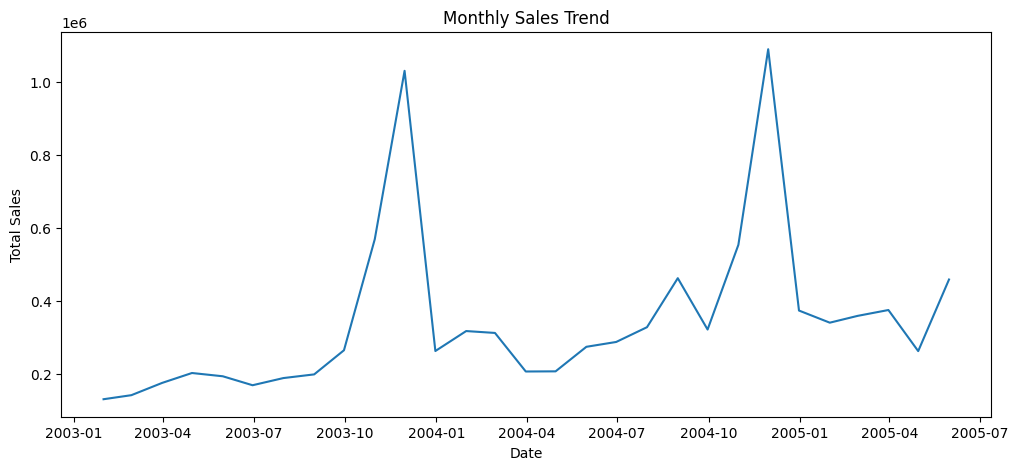

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(monthly_sales['ORDERDATE'], monthly_sales['SALES'])
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_sales['SALES'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -3.628783174623225
p-value: 0.005234006614207446


In [7]:
train = monthly_sales[:-6]
test = monthly_sales[-6:]

In [8]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train['SALES'], order=(1,1,1))
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=6)
arima_forecast

,predicted_mean
23,884539.434995
24,784400.880663
25,735367.581872
26,711358.204001
27,699601.902876
28,693845.376535


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['SALES'], arima_forecast)
rmse = np.sqrt(mean_squared_error(test['SALES'], arima_forecast))

print(" ARIMA MAE:", mae)
print("ARIMA RMSE:", rmse)

 ARIMA MAE: 390804.00182346697
ARIMA RMSE: 400661.31561633723


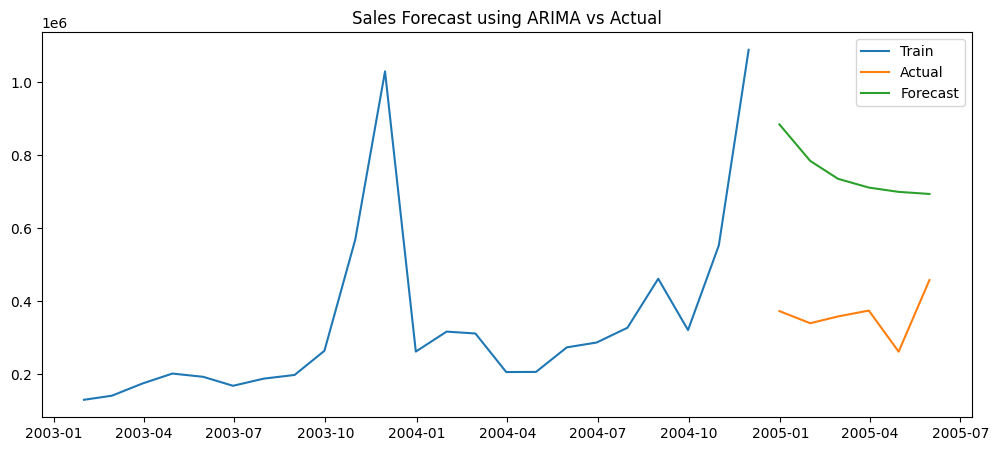

In [10]:
plt.figure(figsize=(12,5))
plt.plot(train['ORDERDATE'], train['SALES'], label='Train')
plt.plot(test['ORDERDATE'], test['SALES'], label='Actual')
plt.plot(test['ORDERDATE'], arima_forecast, label='Forecast')
plt.legend()
plt.title("Sales Forecast using ARIMA vs Actual")
plt.show()

In [11]:
final_arima = ARIMA(monthly_sales['SALES'], order=(1,1,1))
final_fit_arima = final_arima.fit()

future_forecast_arima = final_fit_arima.forecast(steps=12)
future_forecast_arima

,predicted_mean
29,421174.297937
30,409490.461792
31,405769.445835
32,404584.393290
33,404206.983048
34,404086.787120
35,404048.507657
36,404036.316585
37,404032.434027
38,404031.197527


In [12]:
future_dates = pd.date_range(
    start=monthly_sales['ORDERDATE'].max(),
    periods=13,
    freq='ME'
)[1:]

forecast_df_arima = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Sales': future_forecast_arima
})

forecast_df_arima.to_csv('sales_forecast_arima.csv', index=False)

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train['SALES'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

sarima_fit = sarima_model.fit(disp=False)

sarima_forecast = sarima_fit.forecast(steps=6)
sarima_forecast

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,predicted_mean
23,390785.026220
24,464440.101257
25,466188.867816
26,376667.178991
27,383267.667963
28,446380.859957


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['SALES'], sarima_forecast)
rmse = np.sqrt(mean_squared_error(test['SALES'], sarima_forecast))

print("SARIMA MAE:", mae)
print("SARIMA RMSE:", rmse)

SARIMA MAE: 64400.12204823721
SARIMA RMSE: 84181.97073960233


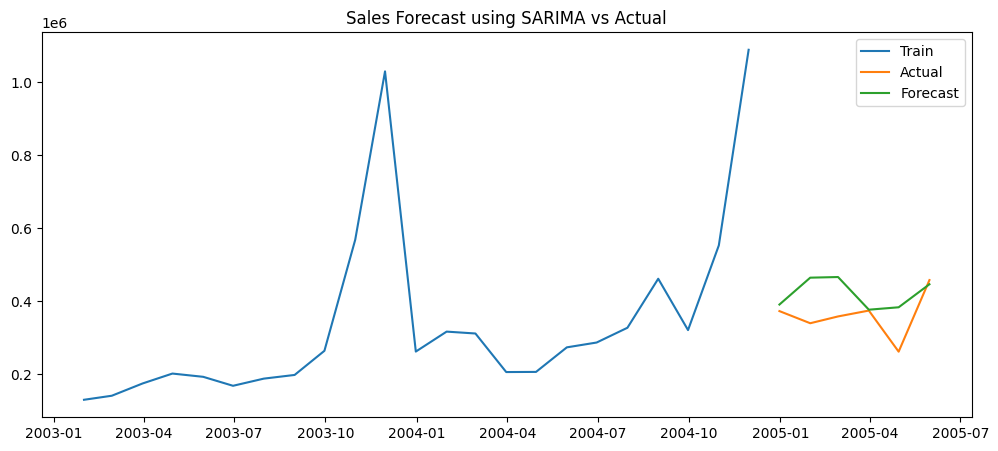

In [15]:
plt.figure(figsize=(12,5))
plt.plot(train['ORDERDATE'], train['SALES'], label='Train')
plt.plot(test['ORDERDATE'], test['SALES'], label='Actual')
plt.plot(test['ORDERDATE'], sarima_forecast, label='Forecast')
plt.legend()
plt.title("Sales Forecast using SARIMA vs Actual")
plt.show()

In [16]:
final_sarima = SARIMAX(
    monthly_sales['SALES'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

final_fit_sarima = final_sarima.fit(disp=False)

future_forecast_sarima = final_fit_sarima.forecast(steps=12)
future_forecast_sarima

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,predicted_mean
29,4.639968e+05
30,4.982865e+05
31,6.210251e+05
32,4.901159e+05
33,7.124631e+05
34,1.221951e+06
35,5.387365e+05
36,5.106891e+05
37,5.277547e+05
38,5.406801e+05


In [17]:
future_dates = pd.date_range(
    start=monthly_sales['ORDERDATE'].max(),
    periods=13,
    freq='ME'
)[1:]

forecast_df_arima = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Sales': future_forecast_sarima
})

forecast_df_arima.to_csv('sales_forecast_sarima.csv', index=False)